In [2]:
import warnings
warnings.filterwarnings('ignore')
# import package
import numpy as np
import os
#5장에서 소개한 moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 7.5 부스팅

- 부스팅은 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법으로 앞의 모델을 보완해 나가면서 일련의 예측기를 학습시키는 것
- 부스팅의 종류: 에이다부스트, 그레이디언트 부스팅

## 7.5.1 에이다부스트
- 이전 예측기를 보완하는 새로운 예측기를 만드는 방법은 이전 모델이 과소적합했던 훈련 샘플의 가중치를 높이는 방법으로 에이다부스트에서 사용하는 방식임.

ex)

(1) 에이다 부스트는 분류기를 만들 때 먼저 알고리즘이 기반이 되는 첫번쨰 분류기를 훈련 세트에서 훈련시키고 예측을 만듦, 그 다음에 알고리즘이 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높임.

(2) 두번쨰 분류기는 업데이트된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측을 만듦, 그 다음에 다시 가중치를 업데이트함.

- 에이다부스트 알고리즘

(1) j번째 예측기의 가중치가 적용된 에러율

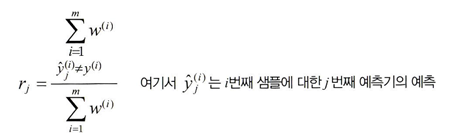

(2) 예측기 가중치

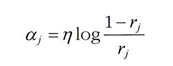

(3) 샘플의 가중치르 업데이트해 잘못 분류된 샘플의 가중치가 증가

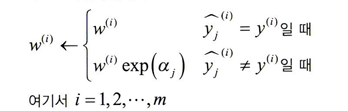

(4) 모든 샘플의 가중치를 정규화함.

(5) 마지막으로 새 예측기가 업데이트된 가중치를 사용해 훈련되고 전체 과정이 반복됨. 알고리즘이 지정된 예측기 수에 도달하거나 완벽한 예측기가 만들어지면 중지됨.

  - 예측을 할 때, 에이다 부스트는 단순히 모든 예측기의 예측을 계산하고 예측기 가중치를 더해 예측결과를 만들고 가중치 합이 가장 큰 클래스가 예측결과가 됨.

  - 사이킷런은 SAMME라는 에이다부스트의 다중 클래스 버전을 사용

In [5]:
# 사이킷런의 AdaBopstClassifier을 사용해 200개의 아주 얕은 결정트리를 기반으로 하는 에이다부스트 분류기를 훈련시킴.
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME', learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

## 7.5.2 그레이디언트 부스팅
- 에이다부스팅처럼 그레이디언트 부스팅은 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가
- 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 잔여 오차에 새로운 예측기를 학습


In [6]:
# 그레이디언트 트리 부스팅, 그레이디언트 부스티드 회귀 트리
from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2)

In [7]:
# 첫번째에 생긴 잔여오차에 두번째 DecisionTreeRegressor 훈련
y2 = tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [8]:
# 두번째 예측기가 만든 잔여오차에 세번째 회귀모델을 훈련
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

In [ ]:
# y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [10]:
# 사이킷런의 GradientBoostingRegressor을 사용해 GBRT 앙상블을 간단하게 훈련시킬 수 있음.트리 수와 같이 앙상블의
# 훈련을 제어하는 매개변수는 물론 RandForestRegressor와 아주 비슷하게 결정 트리의 성장을 제어하는 매개변수를 가지고 있음
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X,y)

GradientBoostingClassifier(learning_rate=1.0, max_depth=2, n_estimators=3)

- learning_rate 매개변수가 각 트리의 기여 정도를 조절
- 축소:  앙상블은 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 예측의 성능은 좋아짐.
- 최적의 트리수를 찾기 위해서 조기 종료 기법을 사용(staged_predict()메서드 사용)

In [14]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train, X_val, y_train, y_val = train_test_split(X, y)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)
errors = [mean_squared_error(y_val, y_pred)
        for y_pred in gbrt.staged_predict(X_test)]
bst_n_estimators = np.argmin(errors) + 1
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train ,y_train)


GradientBoostingRegressor(max_depth=2, n_estimators=1)

In [15]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1, 120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up == 5:
      break # 조기 종료

- GradientBoostingRegressor은 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정할 수 있는 subsample 매개변수도 지원

ex) 확률적 그레이디언트 부스팅: subsample=0.25라 하면, 각 트리는 무작위로 선택된 25%의 훈련 샘플로 학습, 편향이 높아지는 대신 분산은 낮아지게 되고 훈련속도를 상당히 높임.

- 최적화된 그레이디언트 부스팅 구현으로는 XGBoost가 가장 유명함.


In [16]:
import xgboost
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [19]:
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)]) # ,오류로 인해 early_stopping_rounds=2 생략
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.40600
[1]	validation_0-rmse:0.34346
[2]	validation_0-rmse:0.31742
[3]	validation_0-rmse:0.30676
[4]	validation_0-rmse:0.30648
[5]	validation_0-rmse:0.31103
[6]	validation_0-rmse:0.30625
[7]	validation_0-rmse:0.30374
[8]	validation_0-rmse:0.30427
[9]	validation_0-rmse:0.31000
[10]	validation_0-rmse:0.31215
[11]	validation_0-rmse:0.31432
[12]	validation_0-rmse:0.31643
[13]	validation_0-rmse:0.31833
[14]	validation_0-rmse:0.31821
[15]	validation_0-rmse:0.31814
[16]	validation_0-rmse:0.31777
[17]	validation_0-rmse:0.31889
[18]	validation_0-rmse:0.32106
[19]	validation_0-rmse:0.32294
[20]	validation_0-rmse:0.32283
[21]	validation_0-rmse:0.32420
[22]	validation_0-rmse:0.32538
[23]	validation_0-rmse:0.32633
[24]	validation_0-rmse:0.32630
[25]	validation_0-rmse:0.32627
[26]	validation_0-rmse:0.32666
[27]	validation_0-rmse:0.32668
[28]	validation_0-rmse:0.32713
[29]	validation_0-rmse:0.32751
[30]	validation_0-rmse:0.32771
[31]	validation_0-rmse:0.32773
[32]	validation_0-

## 7.6 스태깅
- 스태깅: 앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수를 사용하는 대신 모델을 취합해서 훈련시킬 수 있음.

- 마지막 학습기(블렌더)를 학습시키는 일반적인 방법은 홀드아웃세트를 사용하는 것임.

(1) 먼저 훈련 세트를 두개의 서브셋으로 나눔, 첫번째 서브셋은 첫번쨰 레이어의 예측을 훈련시키기 위해 사용

(2) 첫 번쨰 레이어의 예측기를 사용해 두 번쨰 세트에 대한 예측을 만들어냄. 홀드 아웃 세트의 세개의 예측값은 타깃값은 그대로 쓰고 앞에서 에측한 값을 입력 특성으로 사용하는 새로운 훈련 세트로 만들수 있음.
